# RoadLane Detection



---------------------------------------------------------------

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
from IPython.display import display
import numpy as np
import cv2
%matplotlib inline


This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


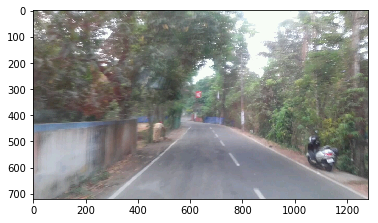

In [29]:
image = mpimg.imread('test_images/p3.jpg')
print('This image is:', type(image), 'with dimesions:', image.shape)
'''[3*width/4, 3*height/5],
                [width/4, 3*height/5],
                [40, height],
        
                [width - 40, height]
                ([960,432],[320,432],[40,720],[1240,720])
                [1000,500],[300,500],[100,720],[1000,720]
                
                '''
plt.imshow(image, cmap='gray')

In [3]:
import os
os.listdir("test_images/")

['Image_1553321141208.jpg',
 'Image_1553321157711.jpg',
 'Image_1553321159704.jpg',
 'Image_1553321161138.jpg',
 'Image_1553321162496.jpg',
 'Image_1553321163760.jpg',
 'Image_1553321164943.jpg',
 'Image_1553321166016.jpg',
 'Image_1553321167094.jpg',
 'Image_1553321168204.jpg',
 'Image_1553321169223.jpg',
 'Image_1553321170386.jpg',
 'Image_1553321172824.jpg',
 'Image_1553321174087.jpg',
 'Image_1553321175248.jpg',
 'Image_1553321176371.jpg',
 'Image_1553321177537.jpg',
 'Image_1553321178676.jpg',
 'Image_1553321179811.jpg',
 'Image_1553321181081.jpg',
 'Image_1553321182427.jpg',
 'Image_1553321183857.jpg',
 'Image_1553321185093.jpg',
 'Image_1553321187284.jpg',
 'Image_1553321188717.jpg',
 'Image_1553321190051.jpg',
 'Image_1553321191317.jpg',
 'Image_1553321192611.jpg',
 'Image_1553321194009.jpg',
 'Image_1553321195444.jpg',
 'Image_1553321196637.jpg',
 'Image_1553321197877.jpg',
 'Image_1553321199095.jpg',
 'Image_1553321200429.jpg',
 'Image_1553321201679.jpg',
 'Image_155332120292

In [30]:
def gaussian_blur(img, kernel_size):
    
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def canny(img, low_threshold, high_threshold):
    
    return cv2.Canny(img, low_threshold, high_threshold)

def region_of_interest(img, vertices):
   
    
    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]  
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
       
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
import math

def perp( a ) :
    b = np.empty_like(a)
   
    b[0] = -a[1]
    
    b[1] = a[0]
    
    return b


def seg_intersect(a1,a2, b1,b2):
    da = a2-a1
    
    db = b2-b1
    
    dp = a1-b1
    
    dap = perp(da)
    
    denom = np.dot( dap, db)
    
    num = np.dot( dap, dp )
   
    
    return (num / denom.astype(float))*db + b1

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):

    
    return cv2.addWeighted(initial_img, α, img, β, λ)

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    
    imgcopy=img.copy()
    largestLeftLineSize = 0
    largestRightLineSize = 0
    largestLeftLine = (0,0,0,0)
    largestRightLine = (0,0,0,0)
    global avgLeft
    global avgRight
    if lines is None:
        avgx1, avgy1, avgx2, avgy2 = avgLeft
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw left line
        avgx1, avgy1, avgx2, avgy2 = avgRight
        cv2.line(imgcopy, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw right line
        return
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            size = math.hypot(x2 - x1, y2 - y1)
            slope = ((y2-y1)/(x2-x1))
            
            if (slope > 0.5): #right
                if (size > largestRightLineSize):
                    largestRightLine = (x1, y1, x2, y2) 
                    
                cv2.line(imgcopy, (x1, y1), (x2, y2), color, thickness)
            elif (slope < -0.5): #left
                if (size > largestLeftLineSize):
                    largestLeftLine = (x1, y1, x2, y2)
                    
                cv2.line(imgcopy, (x1, y1), (x2, y2), color, thickness)

    # Define an imaginary horizontal line in the center of the screen
    # and at the bottom of the image, to extrapolate determined segment
    imgHeight, imgWidth = (img.shape[0], img.shape[1])
    upLinePoint1 = np.array( [200, int(imgHeight - (imgHeight/4))] )
    upLinePoint2 = np.array( [int(imgWidth), int(imgHeight - (imgHeight/4))] )
    downLinePoint1 = np.array( [200, int(imgHeight)] )
    downLinePoint2 = np.array( [1200, int(imgHeight)] )
    
    # Find the intersection of dominant lane with an imaginary horizontal line
    # in the middle of the image and at the bottom of the image.
    p3 = np.array( [largestLeftLine[0], largestLeftLine[1]] )
    
    p4 = np.array( [largestLeftLine[2], largestLeftLine[3]] )
    
    upLeftPoint = seg_intersect(upLinePoint1,upLinePoint2, p3,p4)
    
    downLeftPoint = seg_intersect(downLinePoint1,downLinePoint2, p3,p4)
    
    if (math.isnan(upLeftPoint[0]) or math.isnan(downLeftPoint[0])):
        avgx1, avgy1, avgx2, avgy2 = avgLeft
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw left line
        avgx1, avgy1, avgx2, avgy2 = avgRight
        cv2.line(img,(int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw right line
        return
    cv2.line(img, (int(upLeftPoint[0]), int(upLeftPoint[1])), (int(downLeftPoint[0]), int(downLeftPoint[1])), [0, 190, 255], 8) #draw left line
    # Find the intersection of dominant lane with an imaginary horizontal line
    # in the middle of the image and at the bottom of the image.
    p5 = np.array( [largestRightLine[0], largestRightLine[1]] )
    p6 = np.array( [largestRightLine[2], largestRightLine[3]] )
    upRightPoint = seg_intersect(upLinePoint1,upLinePoint2, p5,p6)
    downRightPoint = seg_intersect(downLinePoint1,downLinePoint2, p5,p6)
    if (math.isnan(upRightPoint[0]) or math.isnan(downRightPoint[0])):
        avgx1, avgy1, avgx2, avgy2 = avgLeft
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw left line
        avgx1, avgy1, avgx2, avgy2 = avgRight
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw right line
        return
    cv2.line(img, (int(upRightPoint[0]), int(upRightPoint[1])), (int(downRightPoint[0]), int(downRightPoint[1])), [0, 190, 255], 8) #draw left line
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
   
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

In [31]:

def process_image(image):

    blurredImage = gaussian_blur(image, 11)
    edgesImage = canny(blurredImage, 40, 50)
    height = image.shape[0]
    width = image.shape[1]
    vertices = np.array( [[
                [1000,500],[300,500],[100,720],[1000,720]
            ]], dtype=np.int32 )
    regionInterestImage = region_of_interest(edgesImage, vertices)
    
    lineMarkedImage = hough_lines(regionInterestImage, 1, np.pi/180, 40, 30, 200)
    #return cv2.cvtColor(regionInterestImage, cv2.COLOR_GRAY2RGB)
    return weighted_img(lineMarkedImage, image)



inDirectory = "test_images"
outDirectory = inDirectory + "_out"
if not os.path.exists(outDirectory):
    os.makedirs(outDirectory)
imageNames = os.listdir(inDirectory + "/")
for imageName in imageNames:
    avgLeft = (0, 0, 0, 0)
    avgRight = (0, 0, 0, 0)
    image = mpimg.imread(inDirectory + "/" + imageName)
    out = process_image(image)
    mpimg.imsave(outDirectory + "/" + imageName, out)
    print("Processed " + outDirectory + "/" + imageName)
    
print("Processing complete.")

Processed test_images_out/Image_1553321157711.jpg
Processed test_images_out/Image_1553321159704.jpg
Processed test_images_out/Image_1553321162496.jpg
Processed test_images_out/Image_1553321163760.jpg
Processed test_images_out/Image_1553321164943.jpg
Processed test_images_out/Image_1553321166016.jpg


e:\proj\code1\venv\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
e:\proj\code1\venv\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in multiply


Processed test_images_out/Image_1553321167094.jpg
Processed test_images_out/Image_1553321168204.jpg
Processed test_images_out/Image_1553321169223.jpg
Processed test_images_out/Image_1553321172824.jpg
Processed test_images_out/p.jpg
Processed test_images_out/p1.jpg
Processed test_images_out/p3.jpg
Processing complete.


In [32]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# reset global state of average values
avgLeft = (0, 0, 0, 0)
avgRight = (0, 0, 0, 0)

white_output = 'trim1out.mp4'
clip1 = VideoFileClip("trim1.mp4")

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video trim1out.mp4.
Moviepy - Writing video trim1out.mp4



Moviepy - Done !
Moviepy - video ready trim1out.mp4
Wall time: 5min 26s


In [37]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))